In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('../data/cleaned_transactions.csv')
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_ratio,dest_balance_ratio
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,True,False,0.942160,0.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,True,False,0.912222,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,False,False,False,True,0.000000,0.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,True,False,False,False,0.000000,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,True,False,0.719188,0.0


In [4]:
df_sample = df.sample(50000, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split

# Separate features and label
X = df_sample.drop('isFraud', axis=1)
y = df_sample['isFraud']

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(40000, 12) (10000, 12)


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape, y_train_resampled.value_counts())


(79888, 12) isFraud
0    39944
1    39944
Name: count, dtype: int64


In [12]:
# Train
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print("LR ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9986
           1       0.02      0.86      0.05        14

    accuracy                           0.95     10000
   macro avg       0.51      0.90      0.51     10000
weighted avg       1.00      0.95      0.97     10000

LR ROC-AUC Score: 0.9232783039111899


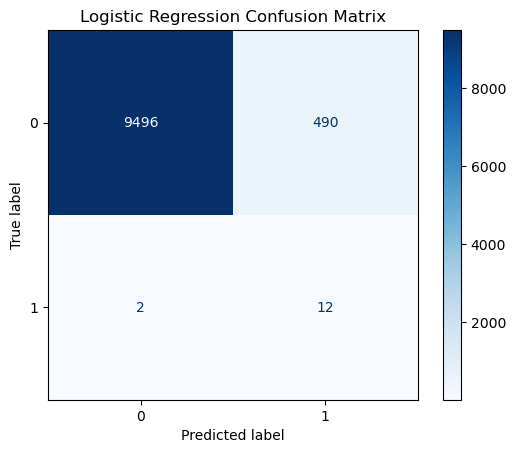

In [13]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.50      0.57      0.53        14

    accuracy                           1.00     10000
   macro avg       0.75      0.79      0.77     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.986892363594747


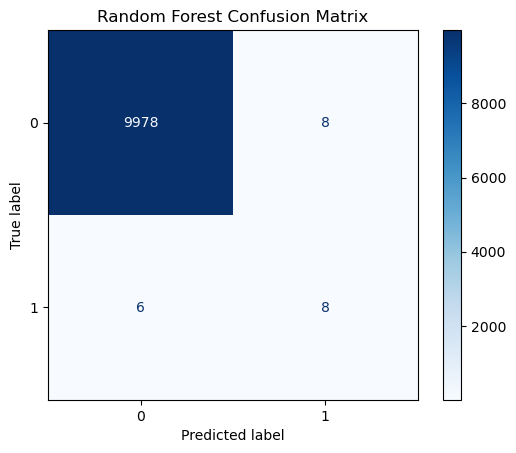

In [15]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

In [16]:
# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
threshold = 0.6
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.67      0.57      0.62        14

    accuracy                           1.00     10000
   macro avg       0.83      0.79      0.81     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.986892363594747


In [17]:
from sklearn.model_selection import cross_val_score

# Run cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

# Print results
print(f"Cross-Validation ROC-AUC Scores: {scores}")
print(f"Mean ROC-AUC Score: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")


Cross-Validation ROC-AUC Scores: [0.95316287 0.95366356 0.95310598 0.95212167 0.99817434]
Mean ROC-AUC Score: 0.9620
Standard Deviation: 0.0181


In [18]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define your base model
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# 2. Define hyperparameter space to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],            # number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],              # depth of trees
    'min_samples_split': [2, 5, 10],                     # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                       # minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],            # number of features considered
    'bootstrap': [True, False]                           # use bootstrap samples?
}

# 3. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                    # try 50 random combinations
    cv=5,                         # 5-fold cross-validation
    verbose=2,                    # show progress
    random_state=42,
    scoring='roc_auc',             # still optimize for ROC-AUC
    n_jobs=-1                     # use all CPU cores
)

# 4. Fit
random_search.fit(X_train_resampled, y_train_resampled)

# 5. Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# 6. Best score during CV
print("Best ROC-AUC Score during CV:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_fe

KeyboardInterrupt: 

In [31]:
# Train
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features='log2', bootstrap=False, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
threshold = 0.6
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.83      0.71      0.77        14

    accuracy                           1.00     10000
   macro avg       0.92      0.86      0.88     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9541500958484737


In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [10]:
xgb_model.fit(X_train_resampled, y_train_resampled)


/home/dosu/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:23:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.52      0.86      0.65        14

    accuracy                           1.00     10000
   macro avg       0.76      0.93      0.82     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9769606019856372


AUPRC (Average Precision): 0.8277


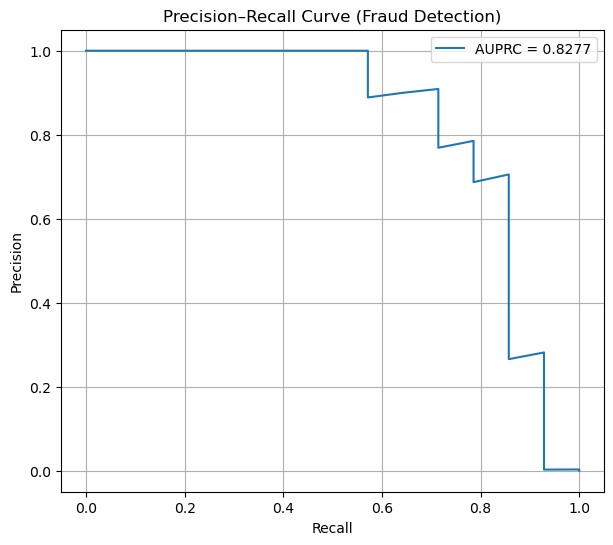

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


# 1️⃣ Compute precision, recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 2️⃣ Compute Area Under the Precision-Recall Curve (AUPRC)
auprc = average_precision_score(y_test, y_pred_proba)
print(f"AUPRC (Average Precision): {auprc:.4f}")

# 3️⃣ Plot the Precision–Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"AUPRC = {auprc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Fraud Detection)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

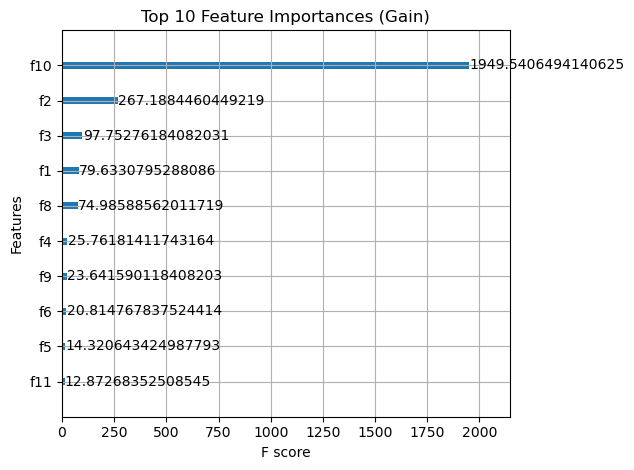

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.show()


In [24]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
sample = X_test_df.sample(100, random_state=42)

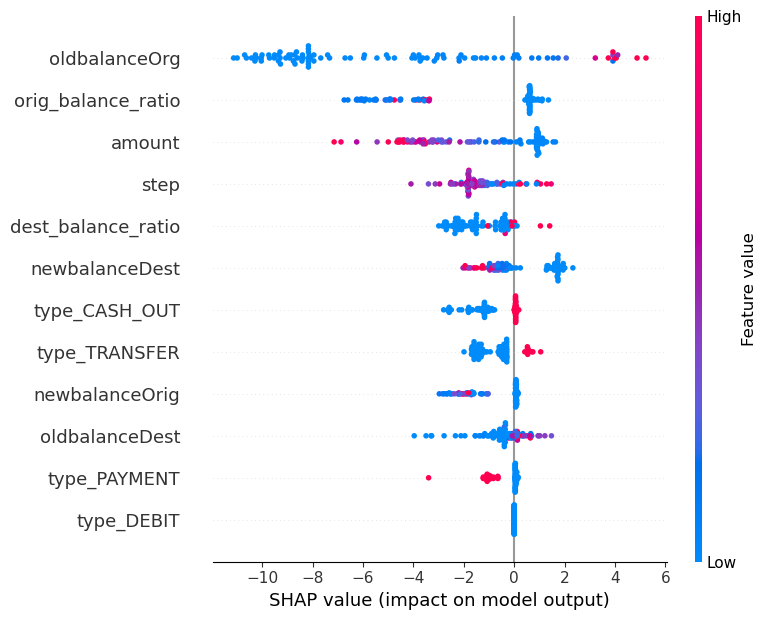

In [25]:
import shap

explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values
shap_values = explainer.shap_values(sample)

# Summary plot
shap.summary_plot(shap_values, sample)


In [26]:
plt.figure()
shap.summary_plot(shap_values, sample, show=False)  
plt.tight_layout()
plt.savefig("../output/shap_summary.png", bbox_inches='tight', dpi=300)
plt.close()

In [19]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from app.preprocess import FeatureEngineer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Columns
numeric_features = [
    "step", "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest",
    "balanceDiffOrig", "balanceDiffDest",
    "orig_balance_ratio", "dest_balance_ratio"
]
categorical_features = ["type"]

preprocessor = Pipeline([
    ("engineer", FeatureEngineer()),
    ("encode", ColumnTransformer([
        ("type", OneHotEncoder(handle_unknown="ignore"), ["type"])
    ], remainder="passthrough"))
])

model_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb_model)
])

In [19]:
data = pd.read_csv('../data/onlinefraud.csv')

In [13]:
X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']

In [20]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 436.9+ MB


In [21]:
model_pipeline.fit(X, y)

/home/dosu/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dosu/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('engineer', FeatureEngineer()),
                                 ('encode',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('type',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['type'])]))])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=Non...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [18]:
joblib.dump(xgb_model, '..src/model/fraud_model.pkl')


['../model/fraud_model.pkl']

In [22]:
joblib.dump(model_pipeline, '../model/fraud_model_pipeline_v1.pkl')

['../model/fraud_model_pipeline_v1.pkl']

In [38]:
import cloudpickle

with open("../model/fraud_model_pipeline_v1_cloud.pkl", "wb") as f:
    cloudpickle.dump(model_pipeline, f)